<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

# Reading and writing binary data

<hr style="border-width:4px; border-color:coral; border-style:solid"/>

This notebook shows you how to write binary data in C and read it in in Python.  The advantages of the binary output is that we store the full precision of the data in the smallest possible file size.  It is very easy to read binary data, and considerably faster than reading data stored as ascii (human-readable) format.

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

## Create a binary data file in C

<hr style="border-width:4px; border-color:coral; border-style:solid"/>

As an example, we first create a sample data file in C.

In [2]:
%%file binary_output.c

#include <stdio.h>
#include <stdlib.h>

int main(int argc, char* argv[])
{
     /* Read 'N' from command line */
    
    int N = atoi(argv[1]);   /* Read argument from command line */
    
    /* ----- Run trapezoid method here with N intervals, compute error ----- */
    
    /* Fake second order error */
    double err = 0.25;
            
    /* Sample binary output for the trapezoidal data on 1 processor*/
    FILE *fout = fopen("trap_01.out","w");        
    fwrite(&N,1,sizeof(int),fout);
    fwrite(&err,1,sizeof(double),fout);
    fclose(fout);
    
    return 0;
}

Overwriting binary_output.c


In [3]:
%%bash

gcc -o binary_output binary_output.c
binary_output 128

This code stores the value `N` as `int` and a length-3 vector `err` is an array of three doubles that stores the 1-norm, the 2-norm and Inf-norm of the error in the solution.  The file is a binary file that should be exactly size

                     sizeof(double) + sizeof(int) = 12 bytes

In [4]:
ls -l trap_01.out

-rw-r--r-- 1 calhoun 12 Feb 24 15:32 trap_01.out


The file is not "human readable", though.

In [5]:
%cat trap_01.out

�         �?

<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

## Read a binary data in Python

<hr style="border-width:4px; border-color:coral; border-style:solid"/>

To read this data in Python, we create a Numpy data type, open the file as binary, 
read from the file, and create a data type which can easily access the binary data.

First, we create a data type to store our error data. 

In [6]:
dt_error = dtype([('N','int32'), ('err','d')])  

dt_error

dtype([('N', '<i4'), ('err', '<f8')])

From this, we see that our data type `dt_error` is one `int` of 4 bytes and a length three array of type double (8 bytes). 

The following code reads our binary file and prints the results as an array of length 1 containing a tuple with entries to type `dt_error`. 

In [7]:
output_file = 'trap_01.out'

fout = open(output_file,"rb")
d = fromfile(fout,dtype=dt_error, count=1)
fout.close()

print(d)

[(128, 0.25)]


### (1) Access data in the datatype tuple directly

We can access the data in the dtype-tuple ('N','err') as

In [8]:
print(d[0])

(128, 0.25)


We need the `[0]` indexing so that we access the first entry in the array of datatypes return.  

We can also extract individual values `(N,err)` by accessing individual entries in the tuple.

In [9]:
N = d[0][0]
err = d[0][1]
print(N,err)

128 0.25


### (2) Assign values directly in one statement

We can assign values to `N` and `err` in one statement:

In [10]:
N,err = d[0]
print(N,err)

128 0.25


### (3) Read directly into a datatype from a file

Or, we can do this directly using from the `fromfile` call.  

*NOTE* : The trailing `[0]` is needed to extract the tuple from the array. 

In [11]:
fout = open(output_file,"rb")
N,err = fromfile(fout,dtype=dt_error, count=1)[0]
fout.close()

print('{:10d} {:12.4e}'.format(N,err))

       128   2.5000e-01


<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

## Reading a table of error data

<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

The above Python code can also be used to read a table of values from a binary file. 

In [12]:
%%file binary_output_table.c

#include <stdio.h>
#include <stdlib.h>

#include <math.h>

int main(int argc, char* argv[])
{
    int rows = 5;
    int N0 = atoi(argv[1]);
    
    /* Create artificialsecond order error */
    double err0 = 0.25;
            
    /* Sample binary output for the trapezoidal data on 1 processor*/
    FILE *fout = fopen("errors_01.out","w"); 
    for(int i = 0; i < rows; i++)
    {
        int factor = pow(2,i);        
        int N = N0*pow(2,i);
        double err = err0/pow(4,i);
        fwrite(&N,1,sizeof(int),fout);
        fwrite(&err,1,sizeof(double),fout);
    }
    fclose(fout);
    
    return 0;
}

Overwriting binary_output_table.c


In [13]:
%%bash

gcc -o binary_output_table binary_output_table.c -lm
binary_output_table 32

To read the table of values, we have to return 

In [14]:
output_file = 'errors_01.out'

fout = open(output_file,"rb")
error_table = fromfile(fout,dtype=dt_error)
fout.close()

print(error_table)

[( 32, 0.25      ) ( 64, 0.0625    ) (128, 0.015625  ) (256, 0.00390625)
 (512, 0.00097656)]


We can access individual tuple entries as

In [15]:
print(error_table[3])

(256, 0.00390625)


<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

## Converting table to a Pandas DataFrame object

<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

Storing the data as a Pandas DataFrame makes it easy to extract our data for plotting. 

In [16]:
import pandas

fout = open(output_file,"rb")
data = fromfile(fout,dtype=dt_error)
fout.close()

df_error = pandas.DataFrame(data)
fstr = {'N' : '{:d}'.format, 'err' : '{:.4e}'.format}
df_error.style.format(fstr)

,N,err
0,32,2.5000e-01
1,64,6.2500e-02
2,128,1.5625e-02
3,256,3.9062e-03
4,512,9.7656e-04


<hr style="border-style:solid; border-width:4px; border-color:coral"/>

## Plotting error results

<hr style="border-style:solid; border-width:4px; border-color:coral"/>

We can extract the N values and error values from the DataFrame, and plot the error results.  The slope of the best-fit line should be close to -2.   This is a good test to see that you are doing your discretization and communication in your MPI code correctly.

<IPython.core.display.Javascript object>


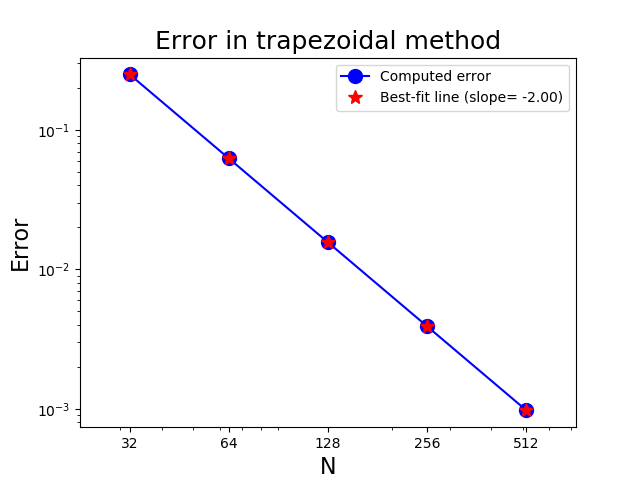

In [17]:
figure(1)
clf()

loglog(df_error['N'],df_error['err'],'b.-',color='b',markersize=20,label="Computed error")

In [18]:
# Add slope to get best fit line
figure(1)

c = polyfit(log(df_error['N']),log(df_error['err']),1)
loglog(df_error['N'],exp(polyval(c,log(df_error['N']))),'r*', markersize=10,\
         label='Best-fit line (slope={:6.2f})'.format(c[0]),linewidth=1)

In [19]:
# Add title, xlabel, ylabel, xticks and a legend

figure(1)

def fix_xticks(Nvec):
    p0 = log2(Nvec[0])
    p1 = log2(Nvec[-1])
    xlim([2**(p0-0.5), 2**(p1+0.5)])
    
    # Make nice tick marks
    pstr = (['{:d}'.format(int(N)) for N in Nvec])
    xticks(Nvec,pstr)

fix_xticks(df_error['N'].values)  # Need numpy array, not a Pandas 'Series'
xlabel("N",fontsize=16)
ylabel("Error",fontsize=16)
title("Error in trapezoidal method",fontsize=18)
legend()

*NOTE* : The above plot uses artificial data so the best-fit line perfectly matches our "error" data.  For the trapezoidal problem, you should see similar error results. 